In [1]:
import os
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


def _calculate_reconstruction_loss(y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss


def calculate_kl_loss(model):
    # wrap `_calculate_kl_loss` such that it takes the model as an argument,
    # returns a function which can take arbitrary number of arguments
    # (for compatibility with `metrics` and utility in the loss function)
    # and returns the kl loss
    def _calculate_kl_loss(*args):
        kl_loss = -0.5 * K.sum(1 + model.log_variance - K.square(model.mu) -
                               K.exp(model.log_variance), axis=1)
        return kl_loss
    return _calculate_kl_loss


class VAE:
    """
    VAE represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2
        self.reconstruction_loss_weight = 1000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[_calculate_reconstruction_loss,
                                    calculate_kl_loss(self)])

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = _calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = calculate_kl_loss(self)()
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss
        return combined_loss

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck with Guassian sampling (Dense
        layer).
        """
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,
                                  name="log_variance")(x)

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        return x


# LEARNING_RATE = 0.0005
# BATCH_SIZE = 32
# EPOCHS = 100


# def load_mnist():
#     (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#     x_train = x_train.astype("float32") / 255
#     x_train = x_train.reshape(x_train.shape + (1,))
#     x_test = x_test.astype("float32") / 255
#     x_test = x_test.reshape(x_test.shape + (1,))

#     return x_train, y_train, x_test, y_test


# def train(x_train, learning_rate, batch_size, epochs):
#     autoencoder = VAE(
#         input_shape=(28, 28, 1),
#         conv_filters=(32, 64, 64, 64),
#         conv_kernels=(3, 3, 3, 3),
#         conv_strides=(1, 2, 2, 1),
#         latent_space_dim=2
#     )
#     autoencoder.summary()
#     autoencoder.compile(learning_rate)
#     autoencoder.train(x_train, batch_size, epochs)
#     return autoencoder


# if __name__ == "__main__":
#     x_train, _, _, _ = load_mnist()
#     autoencoder = train(x_train[:10000], LEARNING_RATE, BATCH_SIZE, EPOCHS)
#     autoencoder.save("model")


2023-03-17 14:24:16.290647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 14:24:16.444246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-17 14:24:16.444283: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-17 14:24:17.557793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [17]:
data = np.load(f'data/rectangle_1/04_training_data/X_norm.npy', allow_pickle=True)
data = data.reshape(data.shape + (1,))
data.shape

(17541, 100, 3, 1)

In [120]:
autoencoder = VAE(
    input_shape=(100, 3, 1),
    conv_filters=[32, 64, 64, 64],
    conv_kernels=[3, 3, 3, 3],
    conv_strides=[1, 1, 1, 1],
    latent_space_dim=32
)
autoencoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 100, 3, 1)]  0           []                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 100, 3, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 100, 3, 32)   0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 100, 3, 32)  128         ['encoder_relu_1[0][0]']         
 on)                                                                                        

In [121]:
autoencoder.compile(0.0005)

In [187]:
autoencoder.train(data, 32, 1000)

Train on 17541 samples
Epoch 1/100
17541/17541 [==============================] - 48s 3ms/sample - loss: 7.5643 - _calculate_reconstruction_loss: 0.0026 - _calculate_kl_loss: 5.0004
Epoch 2/100
17541/17541 [==============================] - 50s 3ms/sample - loss: 7.4758 - _calculate_reconstruction_loss: 0.0025 - _calculate_kl_loss: 4.9493
Epoch 3/100
17541/17541 [==============================] - 48s 3ms/sample - loss: 7.5012 - _calculate_reconstruction_loss: 0.0026 - _calculate_kl_loss: 4.9362
Epoch 4/100
17541/17541 [==============================] - 49s 3ms/sample - loss: 7.4508 - _calculate_reconstruction_loss: 0.0025 - _calculate_kl_loss: 4.9176
Epoch 5/100
17541/17541 [==============================] - 38s 2ms/sample - loss: 7.4518 - _calculate_reconstruction_loss: 0.0025 - _calculate_kl_loss: 4.9431
Epoch 6/100
17541/17541 [==============================] - 43s 2ms/sample - loss: 7.4578 - _calculate_reconstruction_loss: 0.0025 - _calculate_kl_loss: 4.9531
Epoch 7/100
17541/17541

KeyboardInterrupt: 

In [159]:
flight = data

In [188]:
recondst, latent = autoencoder.reconstruct(flight)

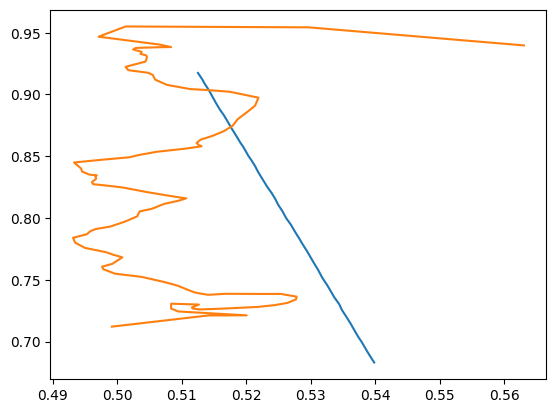

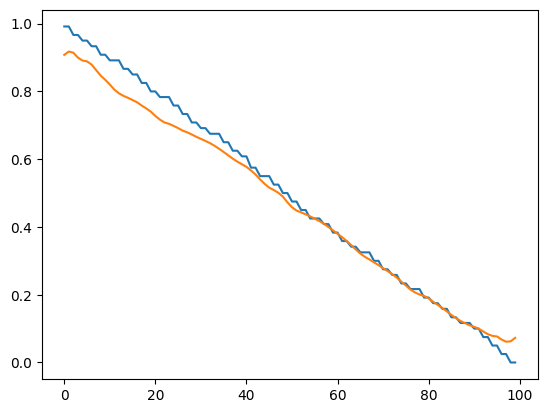

In [198]:
x = 5555

lat_orig = flight[x,:,0,:]
lon_orig = flight[x,:,1,:]
alt_orig = flight[x,:,2,:]

lat_rec = recondst[x,:,0,:]
lon_rec = recondst[x,:,1,:]
alt_rec = recondst[x,:,2,:]

import matplotlib.pyplot as plt
plt.plot(lon_orig, lat_orig)
plt.plot(lon_rec, lat_rec)
plt.show()

plt.plot(alt_orig)
plt.plot(alt_rec)
plt.show()